In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Preparing the dataset

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/bank-full.csv"

data = pd.read_csv(url, sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Select required columns
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month',
           'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
data = data[columns].copy()

### Split the data

In [4]:
# Splitting the data into train (60%), validation (20%), and test (20%)
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [5]:
# Numerical columns to evaluate AUC
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.pop(-1)
numerical_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays']

### Question 1: ROC AUC feature importance


In [6]:
# Calculate the AUC for each numerical variable and check if we need to invert any
auc_scores = {}
for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])  # Invert AUC < 0.5
    auc_scores[col] = auc

# Finding the column with the highest AUC
best_numerical_col = max(auc_scores, key=auc_scores.get)
print(f"auc_scores: {auc_scores}\nThe best numerical column: {best_numerical_col}")

auc_scores: {'age': 0.512185717527344, 'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'campaign': 0.5714543015682159, 'pdays': 0.5901276247352144}
The best numerical column: duration


### Question 2: Training the model

In [7]:
# Convertimos las columnas categóricas en diccionarios para el DictVectorizer
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [8]:
# Calculamos el AUC
auc = roc_auc_score(y_val, y_pred)

# Imprimimos el AUC
print(f"AUC of the model on the validation dataset: {auc:.3f}")

AUC of the model on the validation dataset: 0.900


### Question 3: Precision and Recall

In [9]:
scores = []

# Create an array of thresholds
thresholds = np.linspace(0, 1, 101)

# Loop through each threshold to calculate true positives (tp), false positives (fp), false negatives (fn), and true negatives (tn)
for t in thresholds:
        # Identify actual positive and negative instances in the validation set
        actual_positive = (y_val == "yes")
        actual_negative = (y_val == "no")

        # Predict positive and negative based on the current threshold
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # Calculate true positives, true negatives, false positives, and false negatives
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

# Define column names for the DataFrame
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# Calculate precision (p) and recall(r)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)


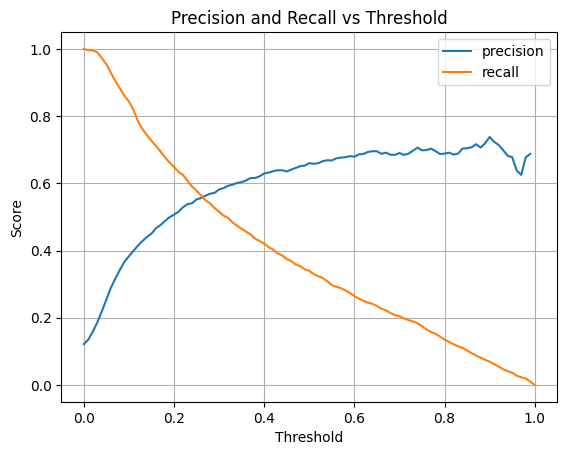

In [10]:
# Graficamos precisión y recall
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# This is done by checking where the sign of the difference between precision and recall changes
diff = np.argwhere(np.diff(np.sign(np.array(df_scores["p"]) - np.array(df_scores["r"])))).flatten()

# Print the threshold
print(f"The threshold precision and recall curves intersect is {df_scores.loc[diff[0]]['threshold']}.")

The threshold precision and recall curves intersect is 0.26.


### Question 4: F1 score

In [12]:
# Initialize a list to store scores for each threshold
f1_scores = []

# Loop through each threshold to calculate the F1 score
for t in thresholds:
    # Predict positive and negative based on the current threshold
    predict_positive = (y_pred >= t)

    # Calculate true positives, false positives, and false negatives
    tp = (predict_positive & actual_positive).sum()  # True Positives
    fp = (predict_positive & actual_negative).sum()  # False Positives
    fn = (predict_negative & actual_positive).sum()  # False Negatives

    # Calculate precision and recall, avoiding division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    if (precision + recall) > 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0.0  # If both precision and recall are zero, F1 is zero

    f1_scores.append(f1)  # Append F1 score to the list

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]

# Print the threshold at which F1 is maximal
print(f"The threshold that maximizes the F1 score is {max_f1_threshold:.2f}.")

The threshold that maximizes the F1 score is 0.22.


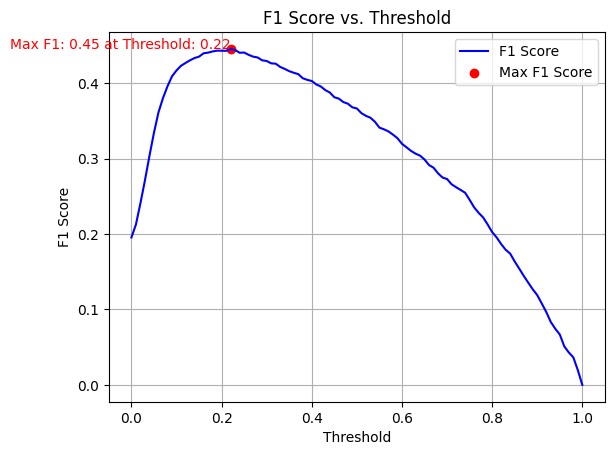

In [13]:
# Plot the F1 scores against the thresholds
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')

# Highlight the maximum F1 score
plt.scatter(max_f1_threshold, f1_scores[max_f1_index], color='red', label='Max F1 Score')
plt.text(max_f1_threshold, f1_scores[max_f1_index],
         f'Max F1: {f1_scores[max_f1_index]:.2f} at Threshold: {max_f1_threshold:.2f}',
         horizontalalignment='right', fontsize=10, color='red')

# Add labels and title
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Question 5: 5-Fold CV

In [15]:
# Assuming df_full_train is your full training DataFrame with 'y' as the target variable
columns = list(data.columns)
columns.remove('y')

# List to store AUC scores for each fold
scores = []

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over each fold
for train_idx, val_idx in kfold.split(df_full_train):
    # Split the data into training and validation sets
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # Prepare target variables
    y_train = df_train['y'].values
    y_val = df_val['y'].values

    # Convert training DataFrame to a list of dictionaries for DictVectorizer
    dicts_train = df_train[columns].to_dict(orient='records')

    # One-hot encode the features
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts_train)

    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Convert validation DataFrame to a list of dictionaries
    dicts_val = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(dicts_val)

    # Predict probabilities for the validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC score for the validation set
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Calculate and print the mean and standard deviation of AUC scores
print('Average AUC score: %.3f +- Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

Average AUC score: 0.906 +- Standard Deviation: 0.006


### Question 6: Hyperparameter Tuning

In [16]:
# Assuming df_full_train is your full training DataFrame with 'y' as the target variable
columns = list(df_full_train.columns)
columns.remove('y')

# Values of C to evaluate
C_values = [0.000001, 0.001, 1]

# Store mean AUC scores and standard deviations for each C
results = {}

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over each C value
for C in C_values:
    scores = []  # List to store AUC scores for each fold
    # Iterate over each fold
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['y'].values
        y_val = df_val['y'].values

        # Convert training DataFrame to a list of dictionaries
        dicts_train = df_train[columns].to_dict(orient='records')

        # One-hot encode the features
        dv = DictVectorizer()
        X_train = dv.fit_transform(dicts_train)

        # Train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Convert validation DataFrame to a list of dictionaries
        dicts_val = df_val[columns].to_dict(orient='records')
        X_val = dv.transform(dicts_val)

        # Predict probabilities for the validation set
        y_pred = model.predict_proba(X_val)[:, 1]

        # Calculate AUC score for the validation set
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Store the mean and standard deviation for the current C value
    results[C] = (round(np.mean(scores), 3), round(np.std(scores), 3))

# Print the results
for C, (mean_score, std_dev) in results.items():
    print(f'C: {C}, Mean AUC: {mean_score}, Standard Deviation: {std_dev}')

# Identify the best C value based on the mean AUC
best_C = max(results, key=lambda x: results[x][0])
print(f'The best C value is: {best_C}')

C: 1e-06, Mean AUC: 0.701, Standard Deviation: 0.009
C: 0.001, Mean AUC: 0.861, Standard Deviation: 0.007
C: 1, Mean AUC: 0.906, Standard Deviation: 0.006
The best C value is: 1
